In [1]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.3”


In [2]:
tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'kaiju', 'map2b', 'metabuli')
# Tools that do not have the correct taxonomy are tested only at the domain level. eg. Kaiju has NCBI taxonomy and MAP2B uses GTDB v202
correct_taxonomy_tools = c('singlem', 'metaphlan', 'kraken', 'sourmash', 'metabuli')

publication_names = data.table(
    tool = tools,
    publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B', 'Metabuli')
)
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

In [3]:
paste('marine',0:4,sep='')

[1] "marine0" "marine1" "marine2" "marine3" "marine4"

In [4]:


d1 = data.table(expand.grid(tool=correct_taxonomy_tools, sample=paste('marine',0:4,sep=''), known=c(0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)))
d1[, method := 'relabund']
d1[tool=='kraken', method := 'reads_wise']
d1[tool=='kaiju', method := 'reads_wise']
d1[tool=='metabuli', method := 'reads_wise']
d1[1:3]

tool,sample,known,method
<fct>,<fct>,<dbl>,<chr>
singlem,marine0,0,relabund
metaphlan,marine0,0,relabund
kraken,marine0,0,reads_wise


In [5]:
# df = pl.read_csv('output_*/opal/known*/*.opal_report')
d2 = d1[, fread(paste('output_',tool,sep='','/opal/known',known,'/',sample,'.opal_report')), by=list(tool,sample,known)]
d2[1:3]

tool,sample,known,tool,rank,metric,sample,value
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [6]:
setnames(d2, c('tool','sample','known','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, sample, known, rank, metric, value)]

In [7]:
fwrite(d3, 'accuracy_results.csv')

In [8]:
bc = d3[metric=='Bray-Curtis distance']
dim(bc)
bc[1:10]

[1] 1925    6

tool,sample,known,rank,metric,value
<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>
singlem,marine0,0,kingdom,Bray-Curtis distance,0.003006890
singlem,marine0,0,phylum,Bray-Curtis distance,0.018006244
singlem,marine0,0,class,Bray-Curtis distance,0.027936104
singlem,marine0,0,order,Bray-Curtis distance,0.035744862
singlem,marine0,0,family,Bray-Curtis distance,0.039321700
singlem,marine0,0,genus,Bray-Curtis distance,0.055912905
singlem,marine0,0,species,Bray-Curtis distance,0.167697764
metaphlan,marine0,0,kingdom,Bray-Curtis distance,0.001805023
metaphlan,marine0,0,phylum,Bray-Curtis distance,0.068414977


In [9]:
bc_medians = bc[,.(median=median(value)), by=.(tool, known, rank)]
bc_medians[1:10]

tool,known,rank,median
<fct>,<dbl>,<chr>,<dbl>
singlem,0,kingdom,0.002158465
singlem,0,phylum,0.011825791
singlem,0,class,0.014263973
singlem,0,order,0.023751238
singlem,0,family,0.035280380
singlem,0,genus,0.047860160
singlem,0,species,0.147277285
metaphlan,0,kingdom,0.001805023
metaphlan,0,phylum,0.068414977


Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


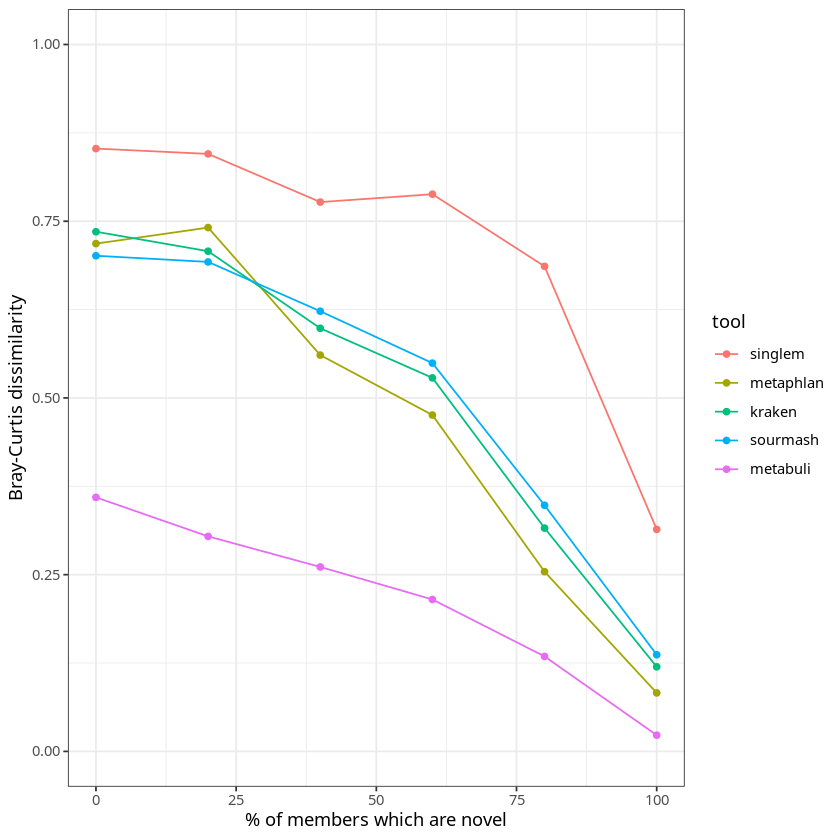

In [10]:

qplot(data=bc_medians[rank=='species' & tool %in% correct_taxonomy_tools & known %in% c(0,20,40,60,80,100)], known, 1-median, colour=tool)+geom_line()+ylab('Bray-Curtis dissimilarity')+xlab('% of members which are novel')+ylim(0,1)

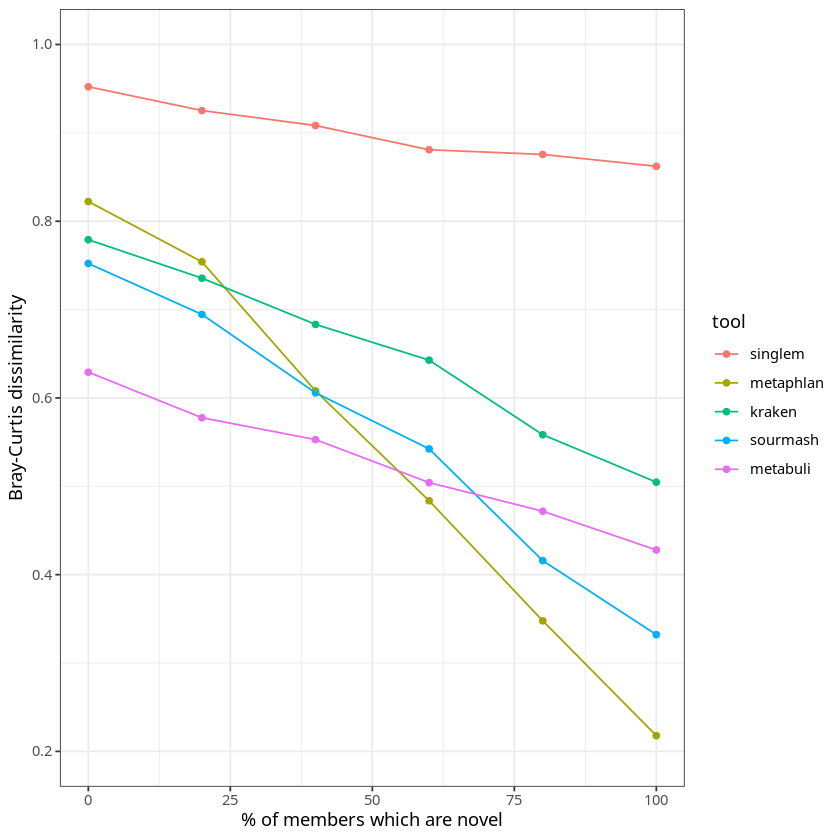

In [11]:
# no legend
# qplot(data=bc_medians[rank=='genus' & tool %in% correct_taxonomy_tools], known, 1-median, colour=tool)+geom_line()+ylab('Bray-Curtis dissimilarity')+xlab('% of members which are novel')+ylim(0.2,1)
qplot(data=bc_medians[rank=='genus' & tool %in% correct_taxonomy_tools & known %in% c(0,20,40,60,80,100)], known, 1-median, colour=tool)+geom_line()+ylab('Bray-Curtis dissimilarity')+xlab('% of members which are novel')+ylim(0.2,1)

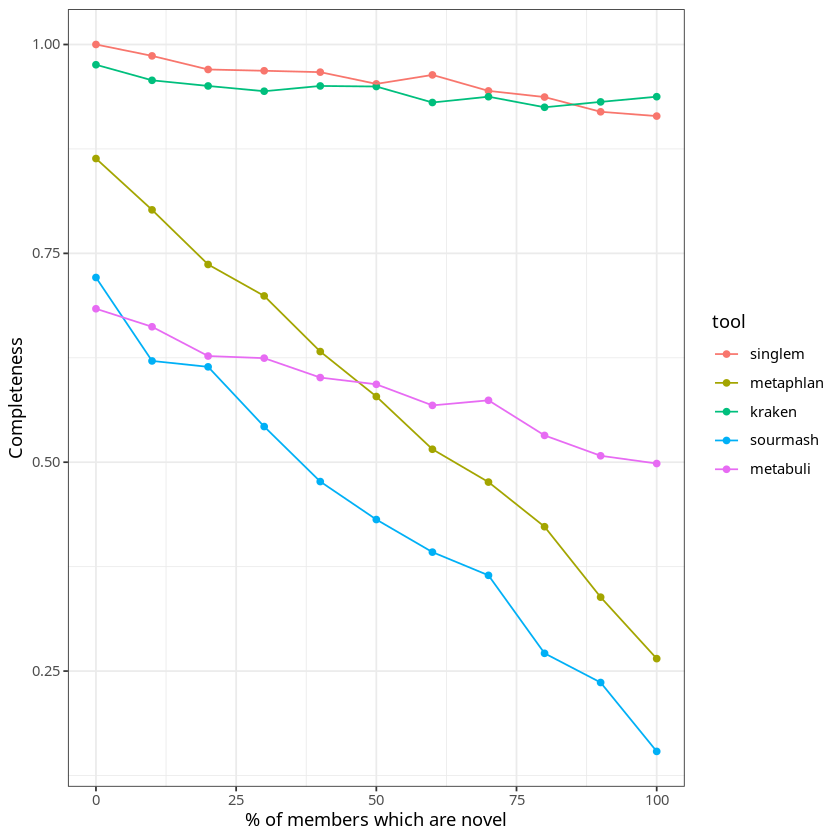

In [12]:
qplot(data=d3[metric=='Completeness'][,.(median=median(value)), by=.(tool, known, rank)][rank=='genus' & tool %in% correct_taxonomy_tools], known, median, colour=tool)+geom_line()+ylab('Completeness')+xlab('% of members which are novel')

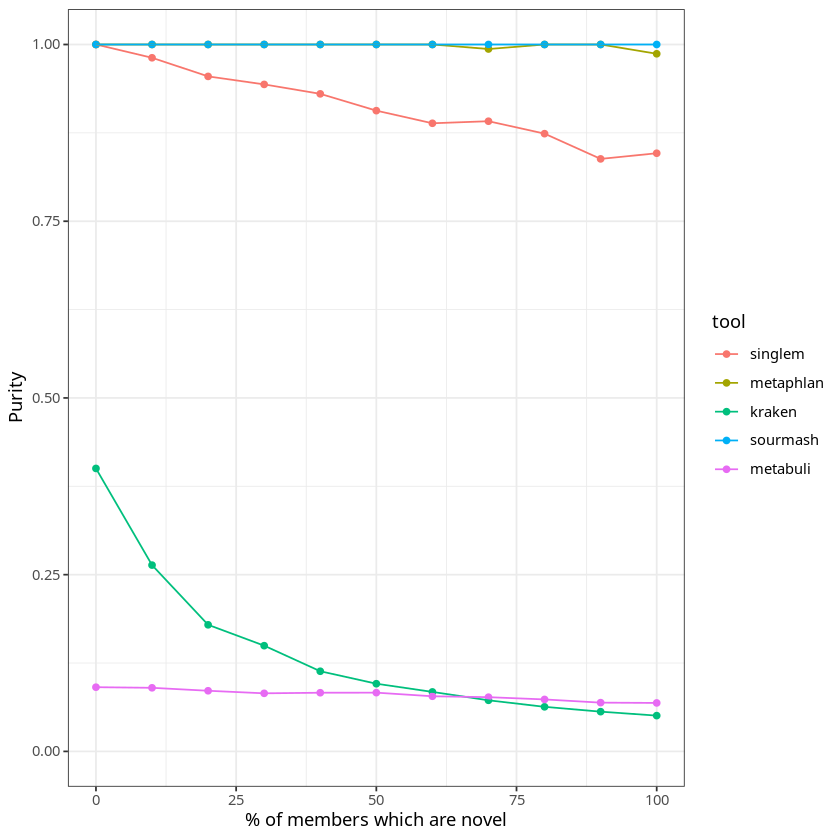

In [13]:
qplot(data=d3[metric=='Purity'][,.(median=median(value)), by=.(tool, known, rank)][rank=='genus' & tool %in% correct_taxonomy_tools], known, median, colour=tool)+geom_line()+ylab('Purity')+xlab('% of members which are novel')+ylim(0,1)

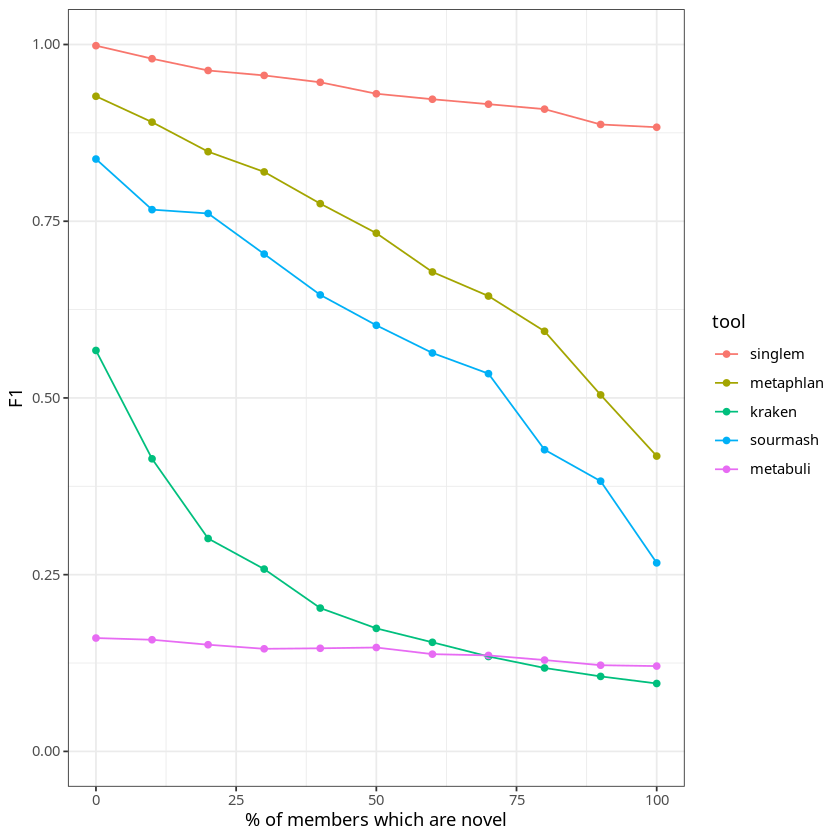

In [14]:
qplot(data=d3[metric=='F1 score'][,.(median=median(value)), by=.(tool, known, rank)][rank=='genus' & tool %in% correct_taxonomy_tools], known, median, colour=tool)+geom_line()+ylab('F1')+xlab('% of members which are novel')+ylim(0,1)

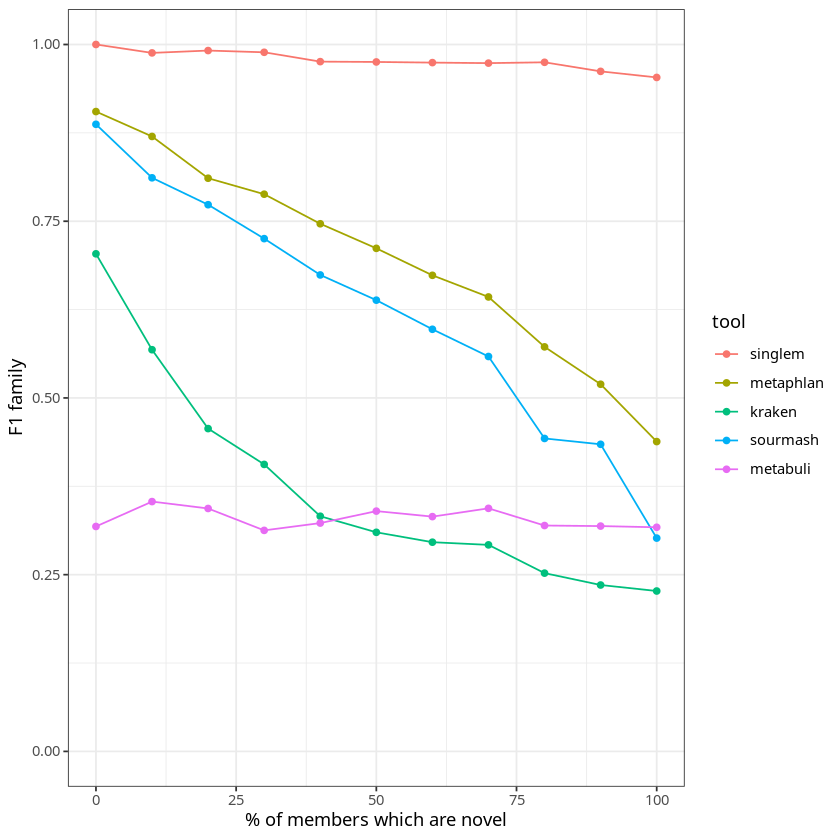

In [15]:
qplot(data=d3[metric=='F1 score'][,.(median=median(value)), by=.(tool, known, rank)][rank=='family' & tool %in% correct_taxonomy_tools], known, median, colour=tool)+geom_line()+ylab('F1 family')+xlab('% of members which are novel')+ylim(0,1)

In [16]:
# How much better when novelty was at its maximum?
second = min(d3[tool != 'singlem'][rank=='genus' & metric=='Bray-Curtis distance' & known==100][,.(median(value)),by=tool]$V1)
singlem = min(d3[tool == 'singlem'][rank=='genus' & metric=='Bray-Curtis distance' & known==100][,.(median(value)),by=tool]$V1)
second
singlem
second - singlem

[1] 0.4953458

[1] 0.137882

[1] 0.3574638

In [17]:
second = max(d3[tool != 'singlem'][rank=='genus' & metric=='F1 score' & known==100][,.(median(value)),by=tool]$V1)
singlem = max(d3[tool == 'singlem'][rank=='genus' & metric=='F1 score' & known==100][,.(median(value)),by=tool]$V1)
second
singlem
second - singlem

[1] 0.4177546

[1] 0.8829431

[1] -0.4651886

# Write overall results for supp data

In [19]:
d3w = d3[tool!='Gold standard'][,.(value=mean(value)), by=list(tool,metric,rank,known)]
d3w[, rank := factor(rank, levels=c('species','genus','family','order','class','phylum','kingdom'))]
d3w[, tool2 := name_to_publication_name(tool, correct_taxonomy_only = T)]
# dcast(d3w, rank+tool2+known~metric, value.var='value')
fwrite(x=dcast(d3w, rank+tool2+known~metric, value.var='value'), file='supp_data1.csv')

rank,tool2,known,Bray-Curtis distance,Completeness,F1 score,False negatives,False positives,Jaccard index,L1 norm error,Purity,Shannon diversity,Shannon equitability,Sum of abundances,Taxon counts,True positives,Unweighted UniFrac (CAMI),Unweighted UniFrac error,Weighted UniFrac (CAMI),Weighted UniFrac error
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,SingleM,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1081.60,0.3211277,0.5301177,0.003746365
NA,SingleM,10,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1169.20,0.3567961,0.5691606,0.003984743
NA,SingleM,20,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1320.00,0.4194011,0.6199984,0.004494294
NA,SingleM,30,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1353.40,0.4422837,0.5775271,0.004132852
NA,SingleM,40,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1438.20,0.4736162,0.6337324,0.004485447
NA,SingleM,50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1511.80,0.5201847,0.6136037,0.004501785
NA,SingleM,60,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1626.40,0.5795500,0.6885670,0.005117087
NA,SingleM,70,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1596.60,0.5790896,0.5874574,0.004410242
NA,SingleM,80,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1689.20,0.6384814,0.6929404,0.005048815
